In [16]:
import numpy as np
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, Naive, SeasonalNaive
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, smape, mase

from utils import plot_metric_bar_multi, evaluate_cv, get_best_model_forecast

## 1) Load Data

In [17]:
# Load in M4 dataset
Y_train_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
Y_test_df = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv')
Y_train_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_train_df['ds'], unit='h')
Y_test_df['ds'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(Y_test_df['ds'], unit='h')

In [18]:
# randomly select 8 series
n_series = 8
uids = Y_train_df['unique_id'].drop_duplicates().sample(8, random_state=23).values
df_train = Y_train_df.query('unique_id in @uids')
df_test = Y_test_df.query('unique_id in @uids')

In [19]:
# Define Error Metrics
from functools import partial
hourly_mase = partial(mase, seasonality=24)
metrics = [hourly_mase, rmse, smape]

In [22]:
import matplotlib.pyplot as plt

fig = plot_series(df_train, df_test.rename(columns={"y": "actual"}), max_ids=4)
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/selected-series.svg', format='svg', bbox_inches='tight')

## 2) Baseline: Naive & SeasonalNaive
Before diving into more sophisticated models, we begin with two classical and interpretable statistical baselines:

**Naive model**: always predicts the last observed value.

**SeasonalNaive model**: predicts that each point will repeat the value observed one season ago (e.g.,the same hour yesterday for hourly data).

In [26]:
# Use Naive and SeasonalNaive model as a baseline
sf_base = StatsForecast(
    models=[Naive(), SeasonalNaive(season_length=24)], 
    freq='H', 
    n_jobs=-1
    )

# Make baseline prediction 
fcst_base = sf_base.forecast(df = df_train, h = 48)

# Evaluate with test dataset
eval_base = df_test.merge(fcst_base, on = ['unique_id', 'ds'])

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pk

In [27]:
# Plotting the baseline result
fig = plot_series(df_train, eval_base, max_ids=4, max_insample_length=5*24)
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/baseline-forecasts.svg', format='svg', bbox_inches='tight')

In [28]:
# Evaluate performance 
metrics_base = evaluate(
    df=eval_base,
    train_df = df_train,
    metrics=metrics,
    agg_fn='mean',
).set_index('metric')
metrics_base

,Naive,SeasonalNaive
metric,,
mase,8.029174,0.993421
rmse,179.520049,66.529088
smape,0.252074,0.065754


## 3) StatsForecast Models
After establishing the baselines, we now move on to a set of classical statistical forecasting models implemented efficiently in StatsForecast. These models automatically estimate optimal parameters for each series.

**AutoARIMA**: Captures autocorrelation patterns and adjusts for both trend and seasonality through differencing and autoregressive components.

**AutoETS**: Exponential smoothing model that automatically selects additive or multiplicative trend/seasonal components. Excellent for smooth, structured data.

**AutoCES**: Complex Exponential Smoothing, which extends ETS by modeling cyclical components in a more flexible way.

**AutoTheta**: A robust, fast method derived from the Theta forecasting model


In [29]:
# Define models
models = [
    AutoARIMA(season_length=24),      # With seasonality set as 24 for hourly data
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    AutoTheta(season_length=24)
]

In [30]:
# Initialize statsforecast 
sf = StatsForecast(
    models=models, 
    freq='H', 
    n_jobs=-1
    )

# Autofit the stats models and make prediction all in one step.
fcst_sf_models = sf.forecast(df = df_train, h = 48, level=[90])

# Evaluate with test dataset
eval_sf_models = df_test.merge(fcst_sf_models, on = ['unique_id', 'ds'])

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pk

In [31]:
# Plot the result
fig = plot_series(df_train, eval_sf_models, max_ids=4, max_insample_length=5*24)
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/statsforecast-predictions.svg', format='svg', bbox_inches='tight')

In [35]:
# Evaluation Metrics
metrics_sf_models = evaluate(
    df= eval_sf_models,
    metrics=metrics,
    train_df = df_train,
    agg_fn='mean',
).set_index('metric')
metrics_sf_models

,AutoARIMA,AutoETS,CES,AutoTheta
metric,,,,
mase,0.801971,1.331669,0.729921,1.868366
rmse,71.456459,122.784231,60.979897,65.105242
smape,0.063301,0.075775,0.079244,0.076261


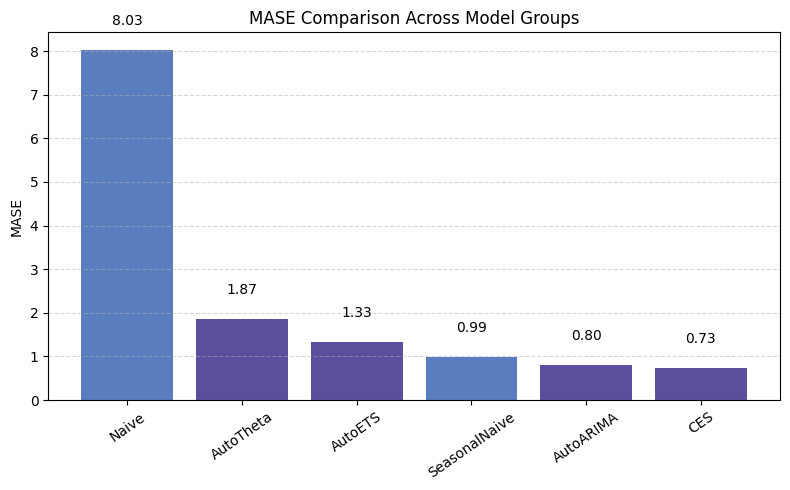

In [47]:
fig = plot_metric_bar_multi(dfs = [metrics_sf_models, metrics_base], metric='mase')
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/model-comparison-bar-chart.svg', format='svg', bbox_inches='tight')

### 4) Cross-Validation with a Rolling Window
In this section, we use rolling-origin cross-validation to select the best model for each time series. Nixtla’s implementation of cross-validation ensures the temporal order is respected, avoiding data leakage and producing a more stable and streamlined evaluation process.

**How it works:**  
1. Start with an initial training window and forecast the next *h* steps.  
2. Slide the window forward by *step_size* and repeat.  
3. Compute error metrics for each window and model.  
4. Select the model with the **lowest average error** for each series.

![Rolling-window cross-validation](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In [39]:
# Run cross-validation with 2 rolling windows of 24 steps each
cv_df = sf.cross_validation(
    df=df_train,
    h=24,          # forecast horizon
    step_size=24,  # roll the window forward by 24 steps each time
    n_windows=2    # number of evaluation windows
)

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pk

In [40]:
# Evaluate model performance using MSE across cross-validation windows
evaluation_df = evaluate_cv(cv_df, mae)

# Count how many times each model was selected as best
evaluation_df['best_statsforecast_model'].value_counts().to_frame().reset_index()

,best_statsforecast_model,count
0,AutoARIMA,3
1,AutoETS,2
2,AutoTheta,2
3,CES,1


After selecting the best model for each series, we visualize the final forecasts alongside the actual test data.

Here, the 90% **prediction interval** (shown as the shaded band) provides an estimate of forecast uncertainty
reflecting how much variation we can expect in future observations based on past residuals.

In [41]:
# Extract the forecasts from the best-performing model for each series
best_fcst_sf = get_best_model_forecast(fcst_sf_models, evaluation_df)
eval_best_sf = df_test.merge(best_fcst_sf, on = ['unique_id', 'ds'])

# Plot forecasts with 90% interval
fig = plot_series(df_train, eval_best_sf, level=[90], max_insample_length=5*24, max_ids=4)
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/best-model-forecasts.svg', format='svg', bbox_inches='tight')

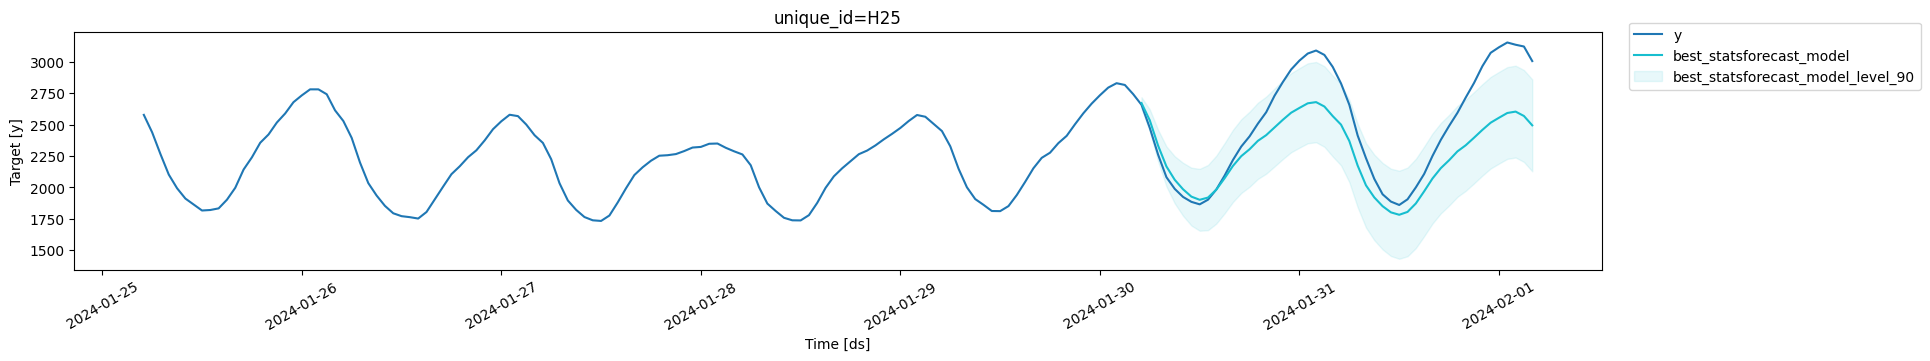

In [68]:
# Extract the forecasts from the best-performing model for each series
best_fcst_sf = get_best_model_forecast(fcst_sf_models, evaluation_df)
eval_best_sf = df_test.merge(best_fcst_sf, on = ['unique_id', 'ds'])

# Filter for H25 only
df_train_h25 = df_train[df_train['unique_id'] == 'H25']
eval_best_sf_h25 = eval_best_sf[eval_best_sf['unique_id'] == 'H25']

# Plot forecasts with 90% interval
fig = plot_series(df_train_h25, eval_best_sf_h25, level=[90], max_insample_length=5*24)
fig

In [42]:
metrics_sf_best = evaluate(
    df=eval_best_sf,
    train_df = df_train,
    metrics=metrics,
    agg_fn='mean',
).set_index('metric')
metrics_sf_best

,best_statsforecast_model
metric,
mase,0.708592
rmse,66.165094
smape,0.057047


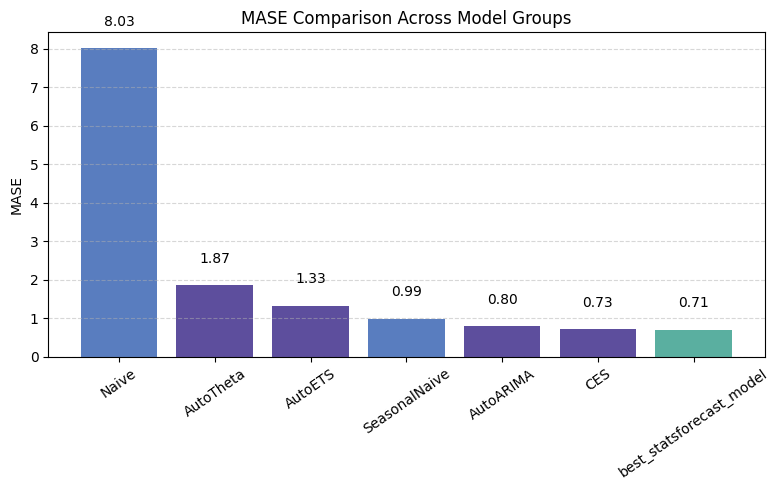

In [48]:
fig = plot_metric_bar_multi(dfs = [metrics_sf_models, metrics_base, metrics_sf_best], metric='mase')
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/complete-comparison.svg', format='svg', bbox_inches='tight')

## 5) Make Forecast with TimeGPT
Produce fast, accurate forecasts using TimeGPT, then compare against our statistical baselines and StatsForecast models.

**Why TimeGPT?**

- Strong out-of-the-box accuracy with minimal tuning

- Handles trend/seasonality/holidays automatically

- Scales to many series with simple APIs

### 5 a) Forecast with TimeGPT-1

In [57]:
# Import necessary packages
import os
from dotenv import load_dotenv
from nixtla import NixtlaClient

# Load environment variables from .env
load_dotenv(override=True)
api_key = os.getenv('NIXTLA_API_KEY')

In [58]:
# Initialize the client
nixtla_client = NixtlaClient(api_key=api_key)

In [52]:
# Simple zero-shot TimeGPT forecast
fcst_timegpt = nixtla_client.forecast(
    df=df_train,
    h=48,         # forecast horizon (next 48 hours)
    freq='H',     # hourly frequency
    level = ['80', '90']
)
fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,H165,2024-01-30 05:00:00,20.847889,26.581411,27.379568,15.114367,14.316211
1,H165,2024-01-30 06:00:00,25.407340,34.487167,34.707325,16.327513,16.107355
2,H165,2024-01-30 07:00:00,49.702620,75.707430,79.375336,23.697813,20.029905
3,H165,2024-01-30 08:00:00,134.175630,152.434750,153.382050,115.916504,114.969210
4,H165,2024-01-30 09:00:00,366.113680,379.054170,381.407230,353.173200,350.820130


In [54]:
# Add finetune steps to make it more accurate
fcst_timegpt_ft = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
    level = ['80', '90'],
    finetune_steps = 10     #Here we use 100 finetune steps. Choose the value base on your usecase
)
fcst_timegpt.head()

INFO:nixtla.nixtla_client:Validating inputs...


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,H165,2024-01-30 05:00:00,20.847889,26.581411,27.379568,15.114367,14.316211
1,H165,2024-01-30 06:00:00,25.407340,34.487167,34.707325,16.327513,16.107355
2,H165,2024-01-30 07:00:00,49.702620,75.707430,79.375336,23.697813,20.029905
3,H165,2024-01-30 08:00:00,134.175630,152.434750,153.382050,115.916504,114.969210
4,H165,2024-01-30 09:00:00,366.113680,379.054170,381.407230,353.173200,350.820130


### 5 b) Forecast with the newly launched TimeGPT-2

In [61]:
# Initialize nixtla_clienct with TimeGPT-2 credentials
nixtla_client = NixtlaClient(api_key=api_key, base_url="https://api-preview.nixtla.io")

In [62]:
fcst_timegpt_2 = nixtla_client.forecast(
    df=df_train,
    h=48,
    freq='H',
    level = ['80', '90'],
    model = 'timegpt-2'
)
eval_tgpt_2 = df_test.merge(fcst_timegpt_2, on = ['unique_id', 'ds'])

INFO:nixtla.nixtla_client:Validating inputs...
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


In [64]:
metrics_tgpt = evaluate(
    df=df_test.merge(fcst_timegpt.rename(columns={'TimeGPT': 'TimeGPT_zero_shot'}), on = ['unique_id', 'ds'])
              .merge(fcst_timegpt_ft.rename(columns={'TimeGPT': 'TimeGPT_finetuned'}), on = ['unique_id', 'ds'])
              .merge(fcst_timegpt_2.rename(columns={'TimeGPT': 'TimeGPT_2'}), on = ['unique_id', 'ds']),
    train_df = df_train,
    metrics=metrics,
    agg_fn='mean',
).set_index('metric')
metrics_tgpt

,TimeGPT_zero_shot,TimeGPT_finetuned,TimeGPT_2
metric,,,
mase,1.118836,0.831705,0.427980
rmse,53.229181,55.354640,27.017126
smape,0.056424,0.071633,0.035508


In [66]:
fig = nixtla_client.plot(df_train, eval_tgpt_2, level=['80', '90'], max_insample_length=5*24, max_ids=4)
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/timegpt-2-forecasts.svg', format='svg', bbox_inches='tight')

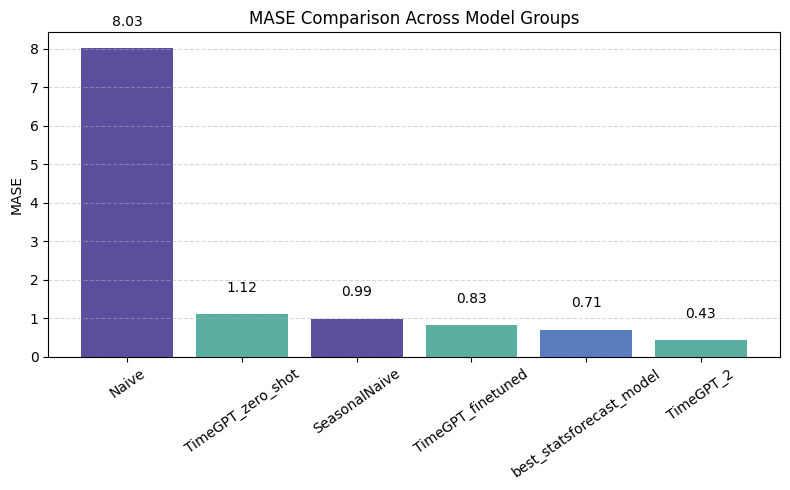

In [65]:
fig = plot_metric_bar_multi(dfs = [metrics_base, metrics_sf_best, metrics_tgpt], metric='mase')
fig.savefig('/Users/khuyentran/nixtla_blog/images/statsforecast-automatic-model-selection/final-comparison-timegpt.svg', format='svg', bbox_inches='tight')